#Homework4: Train different neural networks on MNIST dataset and implement convolution operation using python.

---

## Goal

*Goals:* The goals set up in our homework 4 are listed as follows:

1. we will implement a neural network based on fully connected neural network/multi-layer perceptrons for a given dataset. You might see the overfitting problems.

2. we will implement a LENET for Mnist dataset; (This will be counted as bonus. Definitely, you can choose to skip this one)



To achieve these goals, there are 2 Tasks and small questions attached to each task.

* Task 1: Train Fully Connected Neural Network on MNIST dataset and observe the overfitting issue.
* Task 2: Train and test CNN on MNIST datase (Go to Task 3/Bonus File).

* Task 3 (Cancelled): Implement Convolution Operation in Python from scratch.




---

## *Task 1:* Train Fully Connected Neural Network on MNIST dataset and observe the overfitting issue.

[MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a large database of handwritten digits that is commonly used for training various image processing algorithms. When MNIST was first introduced in 1998, it took several weeks to train a CNN on the state-of-the-art workstation at that time. But now, we can train it efficiently with the help of GPU, and MNIST becomes a good dataset for us to learn how to train an Fully Connected Neural Network or a CNN for studying purpose.

In this task, we are going to build an Fully Connected Neural Network model for MNIST dataset. Before going to the implementation of Fully Connected Neural Network, let's first load the image from MNIST, and conduct pre-processing on the data.

To ease the procedure, we should ultilize a library, i.e., Torchvision. [Torchvision](https://medium.com/swlh/understanding-torchvision-functionalities-for-pytorch-391273299dc9) is a library for Computer Vision that goes hand in hand with PyTorch. It has utilities for efficient Image and Video transformations, some commonly used pre-trained models, and some standard datasets ( torchvision does not come bundled with PyTorch, you will have to install it separately. )



---
** The following is a function to load data from Mnist dataset**

**[Remind]: We are using the SGD(Stochastic Gradient Descent) training optimization. The samples should be shuffled. We thereby need to random_split our train and test dataset. (If interested in it, please check Details about Stochastic Gradient Descent)**

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def load_data(data_root, batch_size=32, trainset_size=0):

  # Load training dataset from MNIST
  train_set = datasets.MNIST(data_root, train=True, download=True,
                            transform=transforms.ToTensor())
  # We randomly split the training dataset if a specified trainset_size is given.
  if trainset_size!=0:
    train_set, other_set = torch.utils.data.random_split(train_set, [trainset_size, len(train_set)-trainset_size])

  # Load testing dataset from MNIST
  test_set = datasets.MNIST(data_root, train=False, download=True,
                            transform=transforms.ToTensor())

  # Create data loader to load images from 2 datasets
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

  print("Number of images in train dataset:",len(train_set))
  print("Number of images in test dataset:",len(test_set))

  return train_loader,test_loader

In [ ]:
import matplotlib.pyplot as plt

batch_size = 2

def plot_image_in_first_batch(data_loader, batch_size):
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    for b in range(batch_size):
      pltsize=1
      plt.figure(figsize=(10*pltsize, pltsize))
      plt.imshow(inputs[b].reshape(28,28), cmap="gray")
      plt.title('Label: '+str(targets[b]))
      plt.show()
    break


train_loader,test_loader = load_data(data_root="./", batch_size=batch_size, trainset_size=1000)

# Visualization of a batch of images in 2 datasets
print("-"*100)
print("Images read from train_loader")
plot_image_in_first_batch(train_loader, batch_size=batch_size)
print("-"*100)
print("Images read from test_loader")
plot_image_in_first_batch(test_loader, batch_size=batch_size)


---
Now, we are ready to build the MLP network, train it, and test it.

Before we build the network, we are given the standard training functions and inferencing functions.

These functions will take the follwoing input parameters:
* data_loader: the data loader created by the *load_data* function
* model: the machine learning model to use
* criterion: the cost function, like cross_entropy introduced in Lecture
* optimizer (only training): the optimizer, like SGD
* epoch (only training): the total epochs for training
* device: cpu (default) or gpu

In [ ]:
def train(data_loader, model, criterion, optimizer, epoch, device='cpu'):
    all_losses = []
    correct = 0
    print_freq = int(len(data_loader)/20)+1
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Trace loss and accuracy & Print log information
        all_losses.append(loss)
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(targets.data.view_as(pred)).cpu().sum()
        if batch_idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    train_acc = 100. * correct / len(data_loader.dataset)
    train_loss = float(sum(all_losses))/len(data_loader.dataset)
    print("Train set: Average loss: {:.4f}, Accuracy {}/{} ({:.2f}%)".format(
        train_loss, correct, len(data_loader.dataset), train_acc))
    return train_loss, train_acc


def inference(data_loader, model, criterion, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss

            pred = outputs.data.max(1, keepdim=True)[1]  # get the index of the class with the maximum log-probability
            correct += pred.eq(targets.data.view_as(pred)).cpu().sum()
    test_acc = 100. * correct / len(data_loader.dataset)
    test_loss /= len(data_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(data_loader.dataset),test_acc))
    return test_loss,test_acc

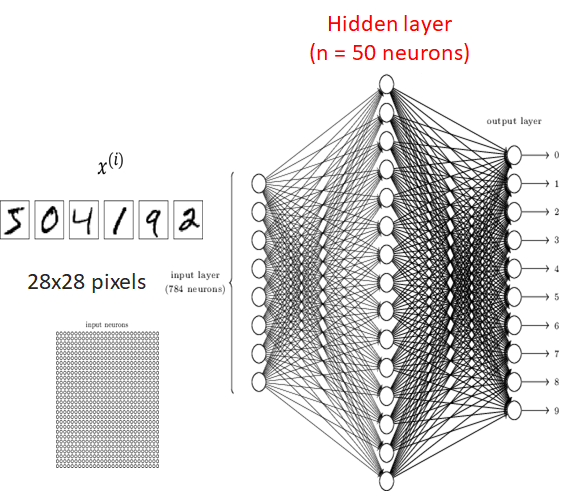

---
Based on the above defined functions, we are now able to define our neural network, train it and test it on MNIST dataset

**[Question 1]: Please fill in missing codes in the MLPNet, where the MLPNet has the following paramters and settings. (30 points)**

1. The hidden layer has the **ReLU** non-linear function.
2. In **forward**, the 28 * 28 MNIST image needs to be flattened by using "x = input.view(-1, 28 * 28)" first.
3. The output dimension of the hidden layer is: 50
4. The output dimension of the output layer is: 10

**[Answer 1]:** (Please fill the below code cell)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()


    def forward(self, x):

        return x

**[Question 2]: Calculate the number of parameters in the MLPNet by hand. Use the following codes to check the correctness of your answer. (10 points)**  

**[Answer 2]:** (Please fill your answer here. Keeping the calculation steps is recommended.)

In [ ]:
import numpy as np
# Setting Experimental Parameters
net = MLPNet()

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

**[Question 3]: Design the experiment to show the overfitting issue caused by the lack of training data. (20 points)**

Before carrying out the comparison, we first fix some training hyperparameters in all the experiements in this lab and we are going to create an *execution()* function to simplify the codes.

Here, we will fix the following training hyperparameters:
* lr = 0.01  # learning rate
* batch_size = 32 # batch size for training
* We use the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the cost function, which contains the softmax to make the output as probability.
* We use the [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer

There are 3 hyperparamters needed to be deteremined by different experiements, including:
1. The neural network (net)
2. The total epochs for training (epochs)
3. The number of training images to be used (trainset_size)

In the exeuction function, we will follow 5 steps to train the network.
1. Use the pre-defined *load_data()* function to create the training and testing data loader
2. Train the model using the pre-defined *train()* function.
3. Test the trained model using the pre-defined *inference()* function.
4. Keep the train_loss, train_acc, test_loss, and test_acc as python lists.
5. Go back to step 2 until we reach the pre-defined maximum epochs.


In [ ]:
def execution(net, epochs, trainset_size):

  print("-"*20,"model properties","-"*20)
  model_parameters = filter(lambda p: p.requires_grad, net.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("Number of parameters: {}".format(params))

  lr = 0.01
  batch_size=32
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)

  print("="*100)
  print("-"*20,"dataset properites","-"*20)
  train_loader,test_loader = load_data(data_root="./", batch_size=batch_size, trainset_size=trainset_size)

  print("="*100)
  print("-"*20,"network training begin","-"*20)

  train_loss, train_acc = [], []
  test_loss, test_acc = [], []
  for epoch in range(0, epochs):
      tr_loss,tr_acc = train(train_loader, net, criterion, optimizer, epoch)
      te_loss,te_acc = inference(test_loader, net, criterion)

      train_loss.append(tr_loss)
      train_acc.append(tr_acc)
      test_loss.append(te_loss)
      test_acc.append(te_acc)

  print("="*100)
  print("-"*20,"plotting loss and accuracy","-"*20)
  # plot the trace of accuracy or loss
  plt.figure(figsize=(5,3))
  plt.plot(range(1,epochs+1), train_acc)
  plt.plot(range(1,epochs+1), test_acc)
  plt.title('Train Accuracy using {} training data in {} epochs'.format(trainset_size,epochs))

  plt.figure(figsize=(5,3))
  plt.plot(range(1,epochs+1), train_loss)
  plt.plot(range(1,epochs+1), test_loss)
  plt.title('Train Loss using {} training data in {} epochs'.format(trainset_size,epochs))

  print("="*100)

  return train_loss,train_acc,test_loss,test_acc

**Now, it's time to train the MLPNet for 100 epochs with 1,000 images, and observe its performance. You need to implement the network and use the *execution()* function to train the network.**

Here we use **%%time** to get the elapsed time for our training process.

In [ ]:
%%time
# Run the training and testing process in the following lines.
# YOU NEED TO FILL THIS CODE CELL


**Next, let's train the MLPNet for 10 epochs with 50,000 images, and observe its performance. You need to implement the network again and use the *execution()* function to train the network.****

In [ ]:
%%time
# Run the training and testing process in the following lines.
# YOU NEED TO FILL THIS CODE CELL


---
Now, you have already seen that the overfitting exists if the training data is much smaller than the number of parameters in the network.

**[Answer 3]:** Please first complete the above program and execute it. Then, you need to fill up the following table. The value to be filled here is the training accuracy and test accuracy at the last epoch.

|                |Training Accuracy|Test Accuracy |    Gap   |
| :------------- | :-------------: |:-----------: |:-------: |
| 1000 @ 100epoch|                 |              |          |
| 50000 @ 10epoch|                 |              |          |


---
## Task 2: Train and test CNN(LENET) on MNIST datase. (This one will be counted as bonus one 50 points)


Now, we are going to see the difference between MLP and CNN.

**[Qustion 5]: Implemente convolution neural network for MNIST dataset (LeNet) and compare it with the equalevent MLP.**

Please Go to Task 2 Codes